In [103]:
#Import required libraries
import pandas as pd
import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('Solarize_Light2')
%matplotlib qt

In [104]:
#Importing given data from excel
data=pd.read_csv("data.csv")

#Finding the Loan type for the given Loan Size
data['Loan_Type(phi)'] = data['Interest'].apply(lambda x: 'M' if (x<=0.028 and x>=0.021) else ('P'  if (x>=0.0599 and x<=0.0609) else('A' if (x>=0.0339 and x<=0.0399) else "")))
data

,Loan_Size,Interest,Rating,Loss,Loan_Type(phi)
0,10,0.021,AAA,0.0002,M
1,25,0.022,BB,0.0058,M
2,4,0.021,A,0.0001,M
3,11,0.027,AA,0.0003,M
4,18,0.025,BBB,0.0024,M
5,3,0.026,AAA,0.0002,M
6,17,0.023,BB,0.0058,M
7,15,0.021,AAA,0.0002,M
8,9,0.028,A,0.0010,M
9,10,0.022,A,0.0010,M


In [105]:
#Initializing parameters for Genetic ALgorithm

max_iter=60     # maximum iteration for the algo to run
n=60                 # population size
N=10                 # Number of customers
prob_mut=0.5     # probability of mutation

#Given predefined loan characteristics
D=60                 # Financial institutions's Deposit
K=0.15               # Reserve Ratio 
delta=0.0025         # Pre-determined Institutional Cost
rT=0.01              # Customer Transaction Rate
rD=0.009             # Deposit Rate 

In [106]:
#Generating initial population

initial_population=[]

while(len(initial_population) < n):
    x = [random.randint(0, 1) for i in range(N)]   # Genrating intial binary string 
    L=0
    for i in range(0,10):
        if(x[i]==1):
            L+=data.Loan_Size[i]                   # Calculation sum of Loan
            
        
    if L<=((1-K)*D):                              # Checking the feasibility
         initial_population.append(x)
                          
    else : 
         continue


In [107]:
#Function to calculate fitness value of  population
def calculate_fitness_population(population):

    fitness=[]
    
    for i in population:
        
        # initialising variables
        loan_revenue_nu=0
        loan_cost_mu=0
        total_transaction_cost_omega=0
        demand_deposit_beta=0
        sum_lambda=0         #loss
        L=0
        loan_revenue_nu=0
        penalty=0
        
        # to calculate sum(loan) value
        for j in range(N):
            if i[j] == 1:
                L += data.Loan_Size[j]
                
                if L>((1-K)*D):           # checking the feasibility and assigning penalty if the condition fails
                        penalty=1000
        
        #to calculate loan characteristics part of fitness function    
        for j in range(N):
            
            if i[j]==1:
                loan_revenue_nu+= (data.Interest[j]*data.Loan_Size[j]) - data.Loss[j]
                loan_cost_mu+=data.Loan_Size[j]*delta
                sum_lambda+=data.Loss[j]
                total_transaction_cost_omega+=rT*((1-K)*D-data.Loan_Size[j])
                
        demand_deposit_beta=rD*D
        fitness.append(loan_revenue_nu+loan_cost_mu+total_transaction_cost_omega-demand_deposit_beta-sum_lambda-penalty)

        
    return fitness

In [108]:
#Function to calculate fitness value of chromosome
def calculate_fitness_chromosome(chromosome):

    fitnessc=0
   # initialising variables
    loan_revenue_nu=0
    loan_cost_mu=0
    total_transaction_cost_omega=0
    demand_deposit_beta=0
    sum_lambda=0         #loss
    L=0
    loan_revenue_nu=0
    penalty=0
     
    # to calculate sum(loan) value
    for j in range(len(chromosome)):
        if chromosome[j] == 1:
            L += data.Loan_Size[j]
                
        if L>((1-K)*D):           # checking the feasibility and assigning penalty if the condition fails
            penalty=1000
        
    #to calculate loan characteristics part of fitness function    
    for j in range(len(chromosome)):
            
        if chromosome[j]==1:
            loan_revenue_nu+= (data.Interest[j]*data.Loan_Size[j]) - data.Loss[j]
            loan_cost_mu+=data.Loan_Size[j]*delta
            sum_lambda+=data.Loss[j]
            total_transaction_cost_omega+=rT*((1-K)*D-data.Loan_Size[j])
                
        demand_deposit_beta=rD*D
        fitnessc=(loan_revenue_nu+loan_cost_mu+total_transaction_cost_omega-demand_deposit_beta-sum_lambda-penalty)

      
    return fitnessc

In [109]:
#Function for Roulette Wheel selection : Selecting chromosomes to choose intial chromosome from

def selection(population,fitness):
    
    selected_population = []
    
    # calculating probability of selection
    fitness_sum=sum(fitness)
    prob_of_select=[x/fitness_sum for x in fitness]
    cum_prob=np.cumsum(prob_of_select)
    
    #generating random number to select chromosomes
    random_no=[random.random() for i in range(len(population))]
    selection_index=cum_prob.searchsorted(random_no)
    
    for i in selection_index:
        selected_population.append(population[i])
        
    
    
    return selected_population  

In [110]:
#Function to perfom mutation and to generate candidate list containing set of 5 possible neighborhood solutions
def mutation(chromosome):
    
    chromosome_mutation=[]
    #list of 5 chromosomes
    for i in range(5):
        cm=chromosome.copy()
        chromosome_mutation.append(cm)
    
    #performs bit-flipping mutation
    for i in range(5):
        for j in range(N):
            if random.random() < prob_mut:
                if chromosome_mutation[i][j]==0:
                    chromosome_mutation[i][j]=1
                else:
                    chromosome_mutation[i][j]=0
    #print(chromosome_mutation)      
    return chromosome_mutation          

In [111]:
#to choose neighborhood solution from a candidate list
def select_neighborhood_solution(candidate_list):
    
    
    n_sol=[]
    
    #choosing neighborhood solution which has maximum fitness value from the candidate list
    fitness_clist=calculate_fitness_population(candidate_list)
    fitness_nsoln=max(fitness_clist)
    nsol_index=fitness_clist.index(fitness_nsoln)
    
    #asipiration criteria if solution is already in Tabu list
    if candidate_list[nsol_index] in Tabu_List:
            if fitness_nsoln > best_fitness:
                n_sol=candidate_list[nsol_index]
            else: 
                candidate_list=mutation(chromosome)
                select_neighborhood_solution(candidate_list)
    else:
        n_sol=candidate_list[nsol_index]
        
    
    return n_sol


In [112]:
#choosing initial chromosome by from selected population
def select_initial_chromosome():
    
    pop=initial_population
    fitness=calculate_fitness_population(pop)
    
    selected_pop=selection(pop,fitness)
    rand=random.randint(0,N-1)
    chromosome=selected_pop[rand]
    fitness_chromosome=calculate_fitness_chromosome(chromosome)
    
    return chromosome,fitness_chromosome

In [113]:
#initialising variables
Tabu_List=[]       #tabu List
Tabu_Count=[]      #Stores Tabu Tenure
chromosome=[]
best_fit=[]

#Calculating Fitness Value of Initial Population
fitness_pop=calculate_fitness_population(initial_population)
#selecting intial solution (chromosome) 
chromosome,fitness_chromosome= select_initial_chromosome() 

#Initialising varibles to find best fitness and best solution
best_fitness=(fitness_chromosome)
best_sol=chromosome

for i in range(max_iter):

    #generating a candidate list to choose chromosome from
    candidate_list=mutation(chromosome)

    #selection of neighborhood solution from candidate list
    neighborhood_soln=select_neighborhood_solution(candidate_list)
    fitness_neighborhoodsoln=calculate_fitness_chromosome(neighborhood_soln)

    #Updation of better chromosome and fitness
    if(fitness_chromosome < fitness_neighborhoodsoln):
        chromosome=neighborhood_soln
        fitness_chromosome=calculate_fitness_chromosome(chromosome)
        
        #Updating Tabulist
        if(len(Tabu_Count)):
            Tabu_Count[:] = [tc - 1 for tc in Tabu_Count]
        #Max-Length of Tabu List is 3 
        if len(Tabu_List)>3:
            Tabu_List.pop(0)
            Tabu_Count.pop(0)
        Tabu_List.append(chromosome)
        Tabu_Count.append(3)   
    #updating best fitness value and best solution
    if best_fitness < fitness_chromosome:
        best_fitness=fitness_chromosome
        best_sol=chromosome
    best_fit.append(fitness_chromosome)

In [114]:
best_sol

[1, 0, 1, 1, 0, 1, 0, 0, 1, 1]

In [115]:
best_fitness

3.3029

In [28]:
Tabu_List

[[1, 0, 0, 1, 1, 0, 0, 0, 0, 1]]

In [15]:
Tabu_Count

[0, 1, 2, 3]

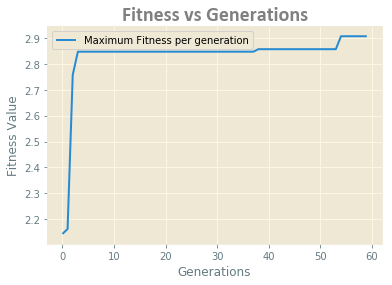

In [16]:
font = {'family':'calibri',
        'color':'grey',
        'weight':'bold',
        'size':20}
plt.plot(best_fit, label="Maximum Fitness per generation")
plt.legend()
plt.title("Fitness vs Generations", fontdict=font)
plt.xlabel("Generations")
plt.ylabel("Fitness Value")
plt.show()